In [1]:
from datasets import load_dataset
hf_dataset = load_dataset("dimun/dates", trust_remote_code=True)

Check the datasets

In [2]:
# Print all the dataset
print(hf_dataset)
# Print length of the dataset
print(len(hf_dataset["train"]))
# Print first example of train
print(hf_dataset["train"][255])

DatasetDict({
    train: Dataset({
        features: ['id', 'transcriptions', 'bboxes_block', 'categories', 'image_path', 'width', 'height'],
        num_rows: 128000
    })
    test: Dataset({
        features: ['id', 'transcriptions', 'bboxes_block', 'categories', 'image_path', 'width', 'height'],
        num_rows: 510
    })
})
128000
{'id': '66248.jpg', 'transcriptions': ['2022', '12', '13'], 'bboxes_block': [[4, 11, 111, 52], [150, 8, 196, 47], [233, 5, 281, 43]], 'categories': [2, 1, 0], 'image_path': '/home/diego/.cache/huggingface/datasets/downloads/extracted/81cda3e0e7ab73fccad83305898e7fcd281858e4c7d3f64568cdedd83a40e451/Date-Synth/images/66248.jpg', 'width': 288, 'height': 61}


Checking one example of the dataset

image id:  60757.jpg
transcriptions ['2016', 'Jul', '30']
categories ['year', 'month', 'day']
width, height:  445 55


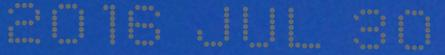

In [3]:
import torch
import random
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from PIL import Image

# Accessing categories from the dataset
categories = hf_dataset["train"].features["categories"].feature

# Take one example from the dataset
random_idx = random.randint(0, hf_dataset["train"].num_rows)
example = hf_dataset["train"][random_idx]

# Open the image and convert it to RGB mode
image = Image.open(example["image_path"]).convert("RGB")

# Extracting labels and bounding boxes from the example
labels = [categories.int2str(x) for x in example['categories']]

# Printing image id, bounding box coordinates, width, and height
print("image id: ", example["id"])
print("transcriptions", example["transcriptions"])
print("categories", categories.int2str(example["categories"]))
print("width, height: ", example["width"], example["height"])

# Printing image
image

Define some data augmentations and normalizations

In [4]:
import albumentations
from albumentations.pytorch import ToTensorV2
import numpy as np

def get_base_augmentations():
    return [
        albumentations.Resize(64, 256),
        albumentations.RandomBrightnessContrast(p=0.5),
        albumentations.GaussianBlur(p=0.3)
    ]

def get_train_augmentation():
    return get_base_augmentations() + [albumentations.ToFloat(), ToTensorV2(p=1.0)]

def get_test_augmentations():
    return [
        albumentations.Resize(64, 256),
        albumentations.ToFloat(),
        ToTensorV2()
    ]

def get_viz_transform():
    return albumentations.Compose(get_base_augmentations())

def get_train_transform():
    return albumentations.Compose(get_train_augmentation())

def get_test_transform():
    return albumentations.Compose(get_test_augmentations())

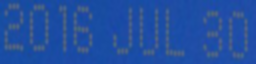

In [5]:
import numpy as np

def visualize_image(image_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    out = get_viz_transform()(image=image)
    image = torch.tensor(out["image"]).permute(2, 0, 1)
    return to_pil_image(image)


image_path = example["image_path"]

# Augmented image
visualize_image(image_path)

Exploring a way to represent the date even when no year or month is available

{2: '2025', 1: '01', 0: '18'}
2025-01-18


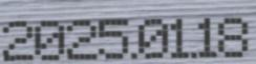

In [6]:
random_idx = random.randint(0, hf_dataset["train"].num_rows)
example = hf_dataset["train"][random_idx]

image_path = example["image_path"]

# Augmented image
dict_date = {k: v for k, v in zip(example["categories"], example["transcriptions"])}
MONTHS = {
    "jan": "01",
    "feb": "02",
    "mar": "03",
    "apr": "04",
    "may": "05",
    "jun": "06",
    "jul": "07",
    "aug": "08",
    "sep": "09",
    "oct": "10",
    "nov": "11",
    "dec": "12"
}

year = dict_date.get(2, "0000").rjust(3, "0").rjust(4, "2")
month = MONTHS.get(dict_date.get(1).lower(), dict_date.get(1))
day = dict_date.get(0, "01")
target = f"{year}-{month}-{day}"

print(dict_date)
print(target)

visualize_image(image_path)

Define the dataset with the cleaned labels if format yyyy-mm-dd

In [7]:
from torchvision.io import read_image
import torch.nn.functional as F

MONTHS = {
    "jan": "01",
    "feb": "02",
    "mar": "03",
    "apr": "04",
    "may": "05",
    "jun": "06",
    "jul": "07",
    "aug": "08",
    "sep": "09",
    "oct": "10",
    "nov": "11",
    "dec": "12"
}

num_classes = 10

class DateDataset(torch.utils.data.Dataset):
    def __init__(self, hugging_face_dataset, transforms=None):
        self.transforms = transforms
        self.base_dataset = hugging_face_dataset

    def __getitem__(self, idx):
        img_path = self.base_dataset[idx]["image_path"]
        img = read_image(img_path) 
        date_str = self._normalize_date(idx)

        # Convert date string to list of tokens
        tokens = torch.Tensor([int(char) for char in date_str if char.isdigit()]).long()

        if self.transforms is not None:
            augmented = self.transforms(image=np.array(img.permute(1, 2, 0)))
            img = augmented['image']

        return img, F.one_hot(tokens, num_classes).t()

    def _normalize_date(self, idx):
        labels = self.base_dataset[idx]['categories']
        transcriptions = self.base_dataset[idx]['transcriptions']
        dict_date = {k: v for k, v in zip(labels, transcriptions)}
        year = dict_date.get(2, "0000").rjust(3, "0").rjust(4, "2")
        month = MONTHS.get(dict_date.get(1).lower(), dict_date.get(1))
        day = dict_date.get(0, "01")
        return f"{year}-{month}-{day}"

    def __len__(self):
        return len(self.base_dataset)

In [9]:
train_dataset = DateDataset(hf_dataset["train"], get_train_transform())
test_dataset = DateDataset(hf_dataset["test"], get_test_transform())

In [10]:
print(train_dataset[0][1])

tensor([[0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# # Vit
# import torch.nn as nn
# from transformers import ViTFeatureExtractor, ViTForImageClassification

# class DateDecoderViT(nn.Module):
#     def __init__(self, num_classes, model_name_or_path='google/vit-base-patch16-224-in21k'):
#         super(DateDecoderViT, self).__init__()
#         self.output_digits = 8 # YYYMMDD
#         self.num_classes = num_classes
#         self.feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
#         self.vit = ViTForImageClassification.from_pretrained(model_name_or_path)
#         self.vit.classifier = nn.Linear(self.vit.classifier.in_features, num_classes * self.output_digits)

#     def forward(self, image, device='cpu'):
#         # Extract features from the image using ViT
#         features = self.feature_extractor(images=image, return_tensors='pt')
#         vit_output = self.vit(pixel_values=features.pixel_values.to(device)).logits # Shape: (batch_size, num_classes * output_digits)

#         return vit_output.view(-1, self.num_classes, self.output_digits) # Shape: (batch_size, num_classes, output_digits))
    
    


Define the model with a resnet50, load the weights and add a custom output layer to finetune.

In [11]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class DateDecoderResNet(nn.Module):
    def __init__(self, num_classes):
        super(DateDecoderResNet, self).__init__()
        self.output_digits = 8 # YYYMMDD
        self.num_classes = num_classes
        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes * self.output_digits)

    def forward(self, image, device='cpu'):
        # Extract features from the image using ResNet
        resnet_output = self.resnet(image.to(device)) # Shape: (batch_size, num_classes * output_digits)

        return resnet_output.view(-1, self.num_classes, self.output_digits) # Shape: (batch_size, num_classes, output_digits))

Define some helper functions to save and load the model

In [12]:
PATH = "exp_date_recognition.pt"

def save_model(model, optimizer, epoch):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)
    
def load_model_checkpoint(model, optimizer):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer


Train the model, this took 13 hours in a RTX 3050 GPU

In [13]:
from torch.utils.data import DataLoader
import torch.optim as optim


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_loader = DataLoader(train_dataset, batch_size=112, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Instantiate the model
num_classes = 10  # Digits 0-9
model = DateDecoderResNet(num_classes)

# move model to the right device1
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Load model and optimizer checkpoint if available
# model, optimizer = load_model_checkpoint(model, optimizer)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        outputs = model(inputs, device)
        loss = criterion(outputs, labels.to(device).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    save_model(model, optimizer, epoch)
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs, device)
            loss = criterion(outputs, labels.to(device).float())
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(test_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")

/home/diego/.cache/pypoetry/virtualenvs/exp-date-recognition--sbm03y3-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/diego/.cache/pypoetry/virtualenvs/exp-date-recognition--sbm03y3-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Loss: 0.2393
Validation Loss: 0.0350
Epoch [2/100], Loss: 0.0381
Validation Loss: 0.0295
Epoch [3/100], Loss: 0.0291
Validation Loss: 0.0301
Epoch [4/100], Loss: 0.0251
Validation Loss: 0.0293
Epoch [5/100], Loss: 0.0218
Validation Loss: 0.0295
Epoch [6/100], Loss: 0.0199
Validation Loss: 0.0391
Epoch [7/100], Loss: 0.0188
Validation Loss: 0.0353
Epoch [8/100], Loss: 0.0171
Validation Loss: 0.0297
Epoch [9/100], Loss: 0.0159
Validation Loss: 0.0372
Epoch [10/100], Loss: 0.0147
Validation Loss: 0.0337
Epoch [11/100], Loss: 0.0139
Validation Loss: 0.0344
Epoch [12/100], Loss: 0.0133
Validation Loss: 0.0420
Epoch [13/100], Loss: 0.0118
Validation Loss: 0.0481
Epoch [14/100], Loss: 0.0121
Validation Loss: 0.0483
Epoch [15/100], Loss: 0.0110
Validation Loss: 0.0378
Epoch [16/100], Loss: 0.0106
Validation Loss: 0.0580
Epoch [17/100], Loss: 0.0101
Validation Loss: 0.0326
Epoch [18/100], Loss: 0.0095
Validation Loss: 0.0414
Epoch [19/100], Loss: 0.0090
Validation Loss: 0.0398
Ep

Testing the model

tensor([[0, 0, 0, 0, 0, 2, 1, 3]], device='cuda:0')


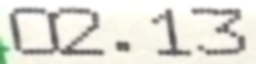

In [91]:

# Accessing categories from the dataset
categories = hf_dataset["test"].features["categories"].feature

# Take one example from the dataset
random_idx = random.randint(0, hf_dataset["test"].num_rows)
example = hf_dataset["test"][random_idx]

# Open the image and convert it to RGB mode
transform = get_test_transform()
image = Image.open(example["image_path"]).convert("RGB")
augmented = transform(image=np.array(image))
model.eval()
output = model(augmented['image'].unsqueeze(0), device)
print(torch.argmax(output, dim=1))
visualize_image(example['image_path'])


In [45]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
            
            outputs = model(inputs, device)
            outputs = torch.argmax(outputs, dim=1)
            labels = torch.argmax(labels, dim=1)
            # Compare the predictions and labels element-wise
            matches = (outputs == labels).all(dim=1)

            # Update the correct and total counts
            correct += matches.sum().item()
            total += labels.size(0)

    accuracy = correct / total

    return accuracy

test_loader = DataLoader(train_dataset, batch_size=64)
accuracy = calculate_accuracy(model, test_loader, device)
print('Accuracy', accuracy)


Accuracy 0.9966796875
